In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Behavorial Cloning  

### Review Articles
- [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/index.html#adam)

### Enrichment Readings 
- [Review: SegNet (Semantic Segmentation)](https://towardsdatascience.com/review-segnet-semantic-segmentation-e66f2e30fb96)
- [Installing TensorFlow Object Detection API on Windows 10](https://medium.com/@marklabinski/installing-tensorflow-object-detection-api-on-windows-10-7a4eb83e1e7b)
- [Multi-Sensor Data Fusion (MSDF) for Driverless Cars, An Essential Primer
](https://medium.com/@lance.eliot/multi-sensor-data-fusion-msdf-for-driverless-cars-an-essential-primer-a1948bb8b57c)
- [How to validate your deep learning model with the Diffgram SDK — Tutorial](https://medium.com/diffgram/how-to-validate-your-deep-learning-model-with-the-diffgram-sdk-tutorial-22234a9a35?_hsenc=p2ANqtz-_o0BTtZu_UHjEOD4taLJqxrDs0xDP_xl-Do12O-pIoMFjzmoS945j4gYYqt96YCTANNiUtfOuRCPnutqNDwwtgSCRMhQ&_hsmi=74444548)
- [How do I design a visual deep learning system in 2019?](https://medium.com/diffgram/how-do-i-design-a-visual-deep-learning-system-in-2019-8597aaa35d03?_hsenc=p2ANqtz-_o0BTtZu_UHjEOD4taLJqxrDs0xDP_xl-Do12O-pIoMFjzmoS945j4gYYqt96YCTANNiUtfOuRCPnutqNDwwtgSCRMhQ&_hsmi=74444548)

### Useful Tips
- [A detailed example of how to use data generators with Keras](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)
- [Writing Custom Keras Generators](https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a)

### Image Database
- [A dataset of images containing...](https://www.kaggle.com/moltean/fruits/downloads/fruits.zip/57)

### General Tips
- It is not necessary to use the left and right images to derive a successful model. Recording recovery driving from the sides of the road is also effective.

**Center Driving**

So that the car drives down the center of the road, it's essential to capture center lane driving. Try driving around the track various times while staying as close to the middle of the track as possible even when making turns.

In the real world, the car would need to stay in a lane rather than driving down the center. But for the purposes of this project, aim for center of the road driving.

**Strategies for Collecting Data**

Now that you have driven the simulator and know how to record data, it's time to think about collecting data that will ensure a successful model. There are a few general concepts to think about that we will later discuss in more detail:

- the car should stay in the center of the road as much as possible
- if the car veers off to the side, it should recover back to center
- driving counter-clockwise can help the model generalize
- flipping the images is a quick way to augment the data
- collecting data from the second track can also help generalize the model
- we want to avoid overfitting or underfitting when training the model
- knowing when to stop collecting more data


# Behavioral Cloning 


This repository contains starting files for the Behavioral Cloning Project.  


## 0. Executive Summary  

Two sets of ConvNet models are used to train ConvNet models to predict steering angle of a simulated car. The first model, which is reletively small, uses a customized arcitecture, whereas the second one is built based on InceptionV3. The training data are simply the scenary, which is collected by the three cameras (left, right, and center) located at the top of the simulated car. To further augment / double training data, we flipped the captured images, with negavtive captured steering angle.  
  
The results were improved as we learned how to better utilize the data and how to use more advanced and bigger models. Based on track-1 (lake track) simulations, the performance of the models are qualitatively sorted as follows (from the best to the worst):  
1. Partial Transfer Learning: Training the Model Based on Inception Architecture, but Trainable Weights (2-3)  
- Training Model Using Already-Provided and Newly Simulated Training Data (3)  
- Training based on all - left, right, and center - camera images using already-provided data (2-1-3)  
- Training based on center camera images using already-provided data (2-1-2)  
- Full Transfer Learning: Training a CNN Model Based on Inception Architecture and Frozen Weights (2-2)  

Based on the experience and results of track-1, I trained two models for the second track (jungle track) two ways:  
   
1. Using the data collected only from track-2  
- Using the combined data, track-1 and 2 together. 

The video of autonomous driving for both results are discussed in the following sections, providing the detals of the procedure to train the models and obtain the results.   

## 1. Introduction  


### 1-1. The Objective of Project
---
The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior 
* Design, train and validate a model that predicts a steering angle from image data
* Use the model to drive the vehicle autonomously around the first track in the simulator. The vehicle should remain on the road for an entire loop around the track.


### 1-2. Dependencies
This lab requires:

* [CarND Term1 Starter Kit](https://github.com/udacity/CarND-Term1-Starter-Kit)

The lab enviroment can be created with CarND Term1 Starter Kit. Click [here](https://github.com/udacity/CarND-Term1-Starter-Kit/blob/master/README.md) for the details.

The following resources can be found in this github repository:
* drive.py
* video.py
* writeup_template.md

The simulator can be downloaded from the classroom. In the classroom, we have also provided sample data that you can optionally use to help train your model.


### 1-3. Data Generation Algorithm  

There are couple of ways to generate data for Keras - and Tensorflow - when the size of the entire dataset is so large that cannot fit into the memory. Moreover, we have to keep in mind that in some cases, even the most state-of-the-art configuration won't have enough memory space to process the data in one goal.  
  
One way is to use `yield` generators. The other way is to generate the dataset on multiple cores in real time - using CPU - and feed it right away to the deep learning model - using GPU. This way, the task of data generation and DL processing can be split between CPU and GPU in an efficient way. To do so, I followed the nice insructions provided in the following link (click on the image below): 

<a href="https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly" target="_blank"><img src="images/data-01.jpg" 
alt="A detailed example of how to use data generators with Keras" width="40%" height="40%" border="10" /></a>  

To do so, a customized version of this approach is implemented in `class DataGenerator4Regression(keras.utils.Sequence):`. The key methods of this `class` are: 

- `__getitem__`: to retrieve an element sitting at an index (this is a special type of array or list, so this method must be overwritten) 
- `on_epoch_end`: to update indexes after each epoch. If reshuffles all the data at the end of each epoch, increasing the randomness and robustness of the model. 
- `__data_generation`: to generate data for training. This method is called at each step of an epoch. THerefore, it reads the data sequence - batch - from the files each time it is called. This method is run by CPU, so any pre-processing will be handled there. 
- `preprocess_rescale_zero_mean`: This is a special method to re-scale the images from 0...255 to -1...+1. This is part of InceptionV3 preprocessing model, while using Transfer learning, but I would rather to implement and process it in CPU instaead of GPU, i.e. making it as a part of Keras/Tensorflow graph. 
  
### 1-4. Strategies for Collecting Data 

Although I used the already-provided data as a valuable source of training, I had to collect more data to enhance the accuracy of the predictions. So I had to use some the tips suggested while collecting more data. 

- **Center Driving**

It's essential to capture center lane driving. Try driving around the track various times while staying as close to the middle of the track as possible even when making turns.  

- **Strategies for Collecting Data**

- the car should stay in the center of the road as much as possible  
- if the car veers off to the side, it should recover back to center  
- driving counter-clockwise can help the model generalize  

  
### 1-5. Data Augmentation and Pre-Processing  
As guided, to augment data, I use `flip` method of openCV module to simply double the size of the training data. This is implmeneted as a part of `__data_generation` method as explained above. So this fucntion would handle reading the data in bateches from the file, preprocess them and augment data based on `flip` method. The hyperparameter `batch_size` would control how much data is loaded into the memory at a step of each epoch. So it can be set to utilize the maximum the amount of memory available for the training, without worrying about memory overflow, if the size of the data is too large - which is the case here. 

  
## 2. Training Models Using Already-Provided Data  

At the first step, I used the images that are already provided for training. I used three different models for training and prediction. 

1. No transfer learning - Training A New CNN Model from Scratch  
- Full Transfer Learning: Training a CNN Model Based on Inception Architecture and Frozen Weights  
- Partial Transfer Learning: Training a CNN Model Based on Inception Architecture and Trainable Weights  

### 2-1. No Transfer Learning: Training A New CNN Model from Scratch   

#### 2-1-1. Model Architecture  

The first model is a CNN, with an architecture similar LeNet's with the following parameters: 

1. Six (6) subsequent CNN layers consists of the following structure:  
    - CNN Layer-1: Kernel Size=(5, 5), Features depth=16
    - CNN Layer-2: Kernel Size=(3, 3), Features depth=32
    - CNN Layer-3: Kernel Size=(3, 3), Features depth=32
    - CNN Layer-4: Kernel Size=(3, 3), Features depth=64
    - CNN Layer-5: Kernel Size=(3, 3), Features depth=64
    - CNN Layer-6: Kernel Size=(1, 1), Features depth=128  

    The following code shows an example of the CNN layers' structures:  
```python
model.add(Conv2D(16, (5, 5), strides=(1, 1), name="conv_layer_01", padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2, 2), name="max_pool_01"))
```
- Four (4) subsequent FC layers consists of the following structure:  
    - FC Layer-1: Number of Parameters=128
    - FC Layer-2: Number of Parameters=64
    - FC Layer-3: Number of Parameters=32
    - FC Layer-4: Number of Parameters=1  

    The following code shows an example of the FC layers' structures (after flattenning):  
```python
model.add(Dense(128, activation=None, name="fc1"))
model.add(Dropout(rate=0.25))
```

In summary: 
```
Total params: 172,609
Trainable params: 171,937
Non-trainable params: 672
```

#### 2-1-2. Training based on center camera images using already-provided data  

Graph below shows the history of `training_loss` and `validation_loss` for training of the first model, using 'center' images. 

<!--a href="images/001-model-conv-6-fc-4-cen-data-01-a.jpg" target="_blank"><img src="images/001-model-conv-6-fc-4-cen-data-01-a.jpg" 
alt="Provided Data, Center Imahes" width="240" height="180" border="10" /></a-->


![Center Images](images/001-model-conv-6-fc-4-cen-data-01-a.jpg "Center Camera Images")

As shown above, validation error is less than training error throught the entire traning process. Generally speaking, 'training error' should most of the time underestimate the 'validation error'. However it is possible for the validation error to be less than the training error. Examples are situations where:

- the training set has many 'hard' cases for training 
- the validation set has mostly 'easy' cases to predict 

Since our problem is a regression problem, it is possible for average training loss to be higher than validation error; becasue, the error - `mse` - can be up-scaled while training by a factor which is related to the data sizes available in training and validatin sets. 

Click on the link below to see the the video of the autonomous car simulation.  

<a href="http://www.youtube.com/watch?feature=player_embedded&v=9Aw39LPy-Lc
" target="_blank"><img src="http://img.youtube.com/vi/9Aw39LPy-Lc/0.jpg" 
alt="Behavioral Cloning, Deep Learning, ConvNet, No Transfer Learning, Center Camera Images" width="640" height="320" border="10" /></a>

#### 2-1-3. Training based on all - left, right, and center - camera images using already-provided data  

Graph below shows the history of `training_loss` and `validation_loss` for training of the first model, using all camera images - left, right, and center cameras. 

![All Images](images/002-model-conv-6-fc-4-data-01-a.jpg "All Images")

As expected, the traiing loss improved by utilizing more data coming all three cameras. Augmenting data using left and right camera has two benefits:  
1. It simply increases the size of the data set by three times. 
- Since we provide a correction factor for left and right camera images, that slightly helps in collecting the off-road center training data. Otherwise, we should have purposedly droven the car from off-center close to the center by ourselves while collecting training data. 

The video of autonomous car simulation is provided in the Youtube link below. The car drives smoothly close to the center of the road most of the time until it reaches the first sharp turn and then it hits the curb and stops. The reason of failure at sharp turn is that majority of the training data collected from either straight or smooth turns; therefore, the network could not learn enough to deal with sharp turns  effectively. As explained further below, I try the following two appraoches to improve the training using:  

1. Transfer learning  
- collecting more training data  

Click on the link below to see the the video of the autonomous car simulation.  

<a href="http://www.youtube.com/watch?feature=player_embedded&v=RgwgBJKoww0
" target="_blank"><img src="http://img.youtube.com/vi/RgwgBJKoww0/0.jpg" 
alt="Behavioral Cloning, Deep Learning, ConvNet, No Transfer Learning, All (center, right, and left) Camera Images" width="640" height="320" border="10" /></a>

Moving forward, I use images from all cameras to train the following models below.  


### 2-2. Full Transfer Learning: Training a CNN Model Based on Inception Architecture and Frozen Weights  

For this full transfer learning model, I use the already-provided data for training. 

#### 2-2-1. Model Architecture  

The full transfer learning model is based on the InceptionV3 model. I dropped the last FC layers and rereplaced them with my own customized  sequence of FC layers with the following parameters: 

1. `GlobalAveragePooling2D` right after loading inception module  

    ```python
    layer_output = GlobalAveragePooling2D()(inception_output)
    ```
- Four (4) subsequent FC layers consists of the following structure:  
    - FC Layer-1: Number of Parameters=128
    - FC Layer-2: Number of Parameters=64
    - FC Layer-3: Number of Parameters=32
    - FC Layer-4: Number of Parameters=1  

    The following code shows an example of the FC layers' structures (after flattenning):  
    ```python
    model.add(Dense(128, activation=None, name="fc1"))
    model.add(Dropout(rate=0.20))
    ```

#### 2-2-2. Results and Discussions  

Graph below shows the history of `training_loss` and `validation_loss` for training of the full transfer learning model.  

![Provided Data, Full Transfer Learning based on InceptionV3](images/020-model-inception-full-data-01-a.jpg "Provided Data, Full Transfer Learning based on InceptionV3")

Although the trend of both at the start of training looks similar to earlier models discussed above, `val_loss` saturates at around `epoch=15` as the training loss still improves, i.e. overfitting situaion.  That can potentially be improved by increasing dropout rate, but more importantly either by using denser layers - more number of parameters at the end - or by using more data. 

Click on the link below to see the the video of the autonomous car simulation.  

<a href="http://www.youtube.com/watch?feature=player_embedded&v=vkUYvJrgHtE
" target="_blank"><img src="http://img.youtube.com/vi/vkUYvJrgHtE/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="640" height="320" border="10" /></a>

The car could not smoothly drive as the steering angle is not correctly estimated. One potential reason may be due to the discrepencies between the nature of our problem - which is regression - and that of InceptionV3 model with frozen weights, which is classification. We should either use a much more denser stack of FC layers at the end of the network, or make the layers to be trainable and use the InceptionV3's initial weights to start with training. We took the latter one, which is discussed further below. 

### 2-3. Partial Transfer Learning: Training a CNN Model Based on Inception Architecture, but Trainable Weights  

For this partial transfer learning model, I use the already-provided data for training. Moreover, the architecture of this model is the same as the full transfer learning model explaied above. However, I set all the layers to be trainable. This way, I would expect to obtain satisfactory results with less number of iteration, `epochs`, as the model's weights are initiualized based on those of InceptionsV3 model. 

#### 2-3-1. Results and Discussions  

Graph below shows the history of `training_loss` and `validation_loss` for training of the partial transfer learning model.  

![Provided Data, Partial Transfer Learning based on InceptionV3](images/021-model-inception-partial-data-01-a.jpg "Provided Data, Partial Transfer Learning based on InceptionV3")

This model effectively benefits from the whole arcitecture of InceptionV3 model. Therefore, it is expected that is should train with a few number of iterations, `epoch` and get very good performance. 

Click on the link below to see the the video of the autonomous car simulation, showing successful driving around the track.  

<a href="http://www.youtube.com/watch?feature=player_embedded&v=x2AojFqaiOQ
" target="_blank"><img src="http://img.youtube.com/vi/x2AojFqaiOQ/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="640" height="320" border="10" /></a>


## 3. Training Model Using Already-Provided and Newly Simulated Training Data  

In this section, I study the effects of adding more simulated training data to the already-provided data. Generally speaking, the already-provided data is good enough for training; However, there are two sharp turns that need special attentions, otherwise the model does not learn how to handle sharp turns well. That's why the first model trained above bumpt into the curb in one of these sharp turns. For this purpose, I use the same small ConvNet as explained above and I collected more data by driving two more laps in which I tried to get close to the center as much as possible. Graph below shows the history of `training_loss` and `validation_loss` for training of the partial transfer learning model.  

![Provided + Newly Simulated Data](images/003-model-conv-6-fc-4-data-02-a.jpg "Provided + Newly Simulated Data")

Click on the link below to see the the video of the autonomous car simulation, showing rather successful driving around the track.  

<a href="http://www.youtube.com/watch?feature=player_embedded&v=9fVuAaGu3wc
" target="_blank"><img src="http://img.youtube.com/vi/9fVuAaGu3wc/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="640" height="320" border="10" /></a>


## 4. Training Models for the Second Track (Jungle Track)  

Based on the experience and results of track-1, I trained two models for the second track (jungle track) two ways:  
   
1. Using the data collected only from track-2  
- Using the combined data, track-1 and 2 together. 

For the first model (track-2 data only), I just used the small ConvNet, as explained above. The autonomous driving simulation goes well and smooth until a moment close to the end of the loop (the youTube link is provided below).   

<a href="http://www.youtube.com/watch?feature=player_embedded&v=DI38bi1IW-k
" target="_blank"><img src="http://img.youtube.com/vi/DI38bi1IW-k/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="640" height="320" border="10" /></a>

For the second model (combined track-1 and track-2 data), I used partial training approach as explained above. The autonomous driving simulation for track-1 (lake) goes completely smooth without any special problem (the youTube link is provided below).  


<a href="http://www.youtube.com/watch?feature=player_embedded&v=3RUCz3mn3so
" target="_blank"><img src="http://img.youtube.com/vi/3RUCz3mn3so/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="640" height="320" border="10" /></a>


The autonomous driving simulation for the second track (jungle) also goes well and smooth until a moment close to the end of the loop, exactly the same moment as the failure time of the first simulation (the youTube link is provided below).   

<a href="http://www.youtube.com/watch?feature=player_embedded&v=zk7IejgIJPw
" target="_blank"><img src="http://img.youtube.com/vi/zk7IejgIJPw/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="640" height="320" border="10" /></a>

Let's take a closer look at the screenshot of the car failure moment, as shown below. It seems that the cat is confused between two roads appearing in front of the camera. Interestingly, the wrong one has clearer view due to lighting condition. For this rather simple training appraoch, one possible remedy is to capture data for that sharp curve and re-train the network again (which is not trained here). 

![Failure moment, jungle track](images/failure-moment-jungle.jpg "Failure moment, jungle track")


## 5. Discussions and Potential Improvement Areas  

- Since this is a regression problem, comparing the performnace of the models should be qualitatively made by checking the videos. Although `loss` and `val_loss` provide reasonable metrics on how well the model would operate, they cannot be used to sort the performance of the models. For exampple, if the car always tries to keep its position close to the center, it has to adjust the steering angle in a small zigzag fashion. That can potentiuially increase `loss` and `val_loss` as compared to those of other models, however, it may lead to the best performance across the models.  
  
  
- The performance of the models can be qualitatively sorted as follows (from the best to the worst):  
  1. Partial Transfer Learning: Training the Model Based on Inception Architecture, but Trainable Weights (2-3)  
  - Training Model Using Already-Provided and Newly Simulated Training Data (3)  
  - Training based on all - left, right, and center - camera images using already-provided data (2-1-3)  
  - Training based on center camera images using already-provided data (2-1-2)  
  - Full Transfer Learning: Training a CNN Model Based on Inception Architecture and Frozen Weights (2-2)  
  
  
- To collect more training data, one may not need to fully drive around the track. Identifying where the car fails to predict the steering angle would significantly simplify the process. For example, in this project, I noticed that the car would potentially fail at sharp turns, because, sharp truns consist only minor portion of the data, however, they are important to consider. In other words, an important portion of the data set - sharp turns in this example - may not have good enough number of data to support training of those portions.  
  



In [2]:
import pickle

In [3]:
from importlib import reload

import selfDrivingCarModules
reload(selfDrivingCarModules)
from selfDrivingCarModules import Sdc

import dataProcessingModules
reload(dataProcessingModules)
from dataProcessingModules import DataGenerator4Regression

Using TensorFlow backend.


In [8]:
model_name = "001-model-conv-6-fc-4-all-data-01"
model_filename = "saved-models/" + model_name + ".h5"
history_filename = "saved-models/" + model_name + ".p"

checkpoint_file = model_filename

In [6]:
from keras.models import load_model
import tensorflow as tf

model = load_model(model_filename, custom_objects={"tf": tf})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


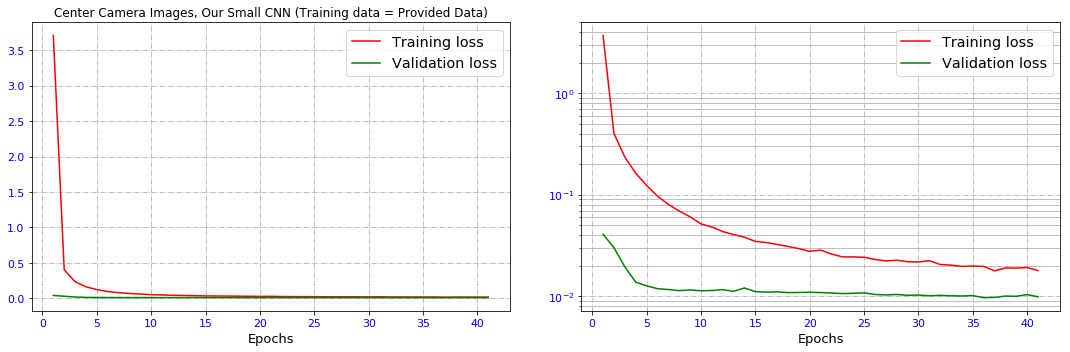

In [4]:
model_name = "001-model-conv-6-fc-4-cen-data-01"
model_filename = "saved-models/" + model_name + ".h5"
history_filename = "saved-models/" + model_name + ".p"

checkpoint_file = model_filename

with open(history_filename, "rb") as file_pi:
    model_history = pickle.load(file_pi)

plot_title = "Center Camera Images, Our Small CNN (Training data = Provided Data)"
plot_file_name="images/" + model_name + "-a.jpg"

Sdc.plot_model_history(model_history["loss"], model_history["val_loss"], plot_title, plot_file_name)

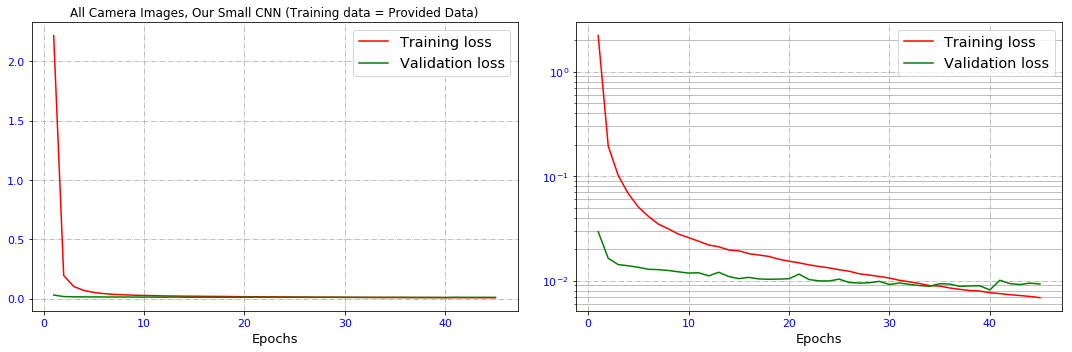

In [5]:
model_name = "002-model-conv-6-fc-4-data-01"
model_filename = "saved-models/" + model_name + ".h5"
history_filename = "saved-models/" + model_name + ".p"

checkpoint_file = model_filename

with open(history_filename, "rb") as file_pi:
    model_history = pickle.load(file_pi)

plot_title = "All Camera Images, Our Small CNN (Training data = Provided Data)"
plot_file_name="images/" + model_name + "-a.jpg"

Sdc.plot_model_history(model_history["loss"], model_history["val_loss"], plot_title, plot_file_name)

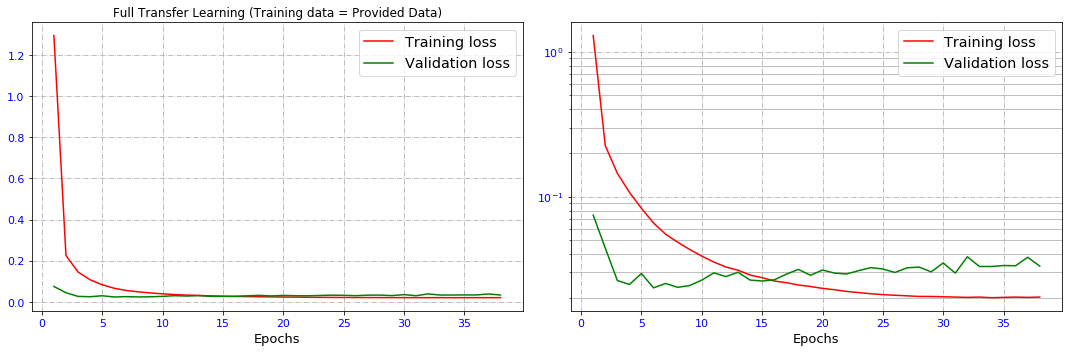

In [6]:
model_name = "020-model-inception-full-data-01"
model_filename = "saved-models/" + model_name + ".h5"
history_filename = "saved-models/" + model_name + ".p"

checkpoint_file = model_filename

with open(history_filename, "rb") as file_pi:
    model_history = pickle.load(file_pi)

plot_title = "Full Transfer Learning (Training data = Provided Data)"
plot_file_name="images/" + model_name + "-a.jpg"

Sdc.plot_model_history(model_history["loss"], model_history["val_loss"], plot_title, plot_file_name)


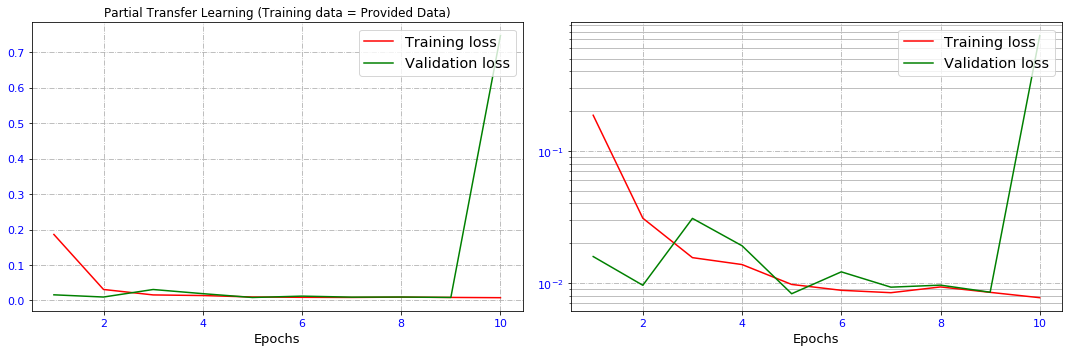

In [7]:
model_name = "021-model-inception-partial-data-01"
model_filename = "saved-models/" + model_name + ".h5"
history_filename = "saved-models/" + model_name + ".p"

checkpoint_file = model_filename

with open(history_filename, "rb") as file_pi:
    model_history = pickle.load(file_pi)

plot_title = "Partial Transfer Learning (Training data = Provided Data)"
plot_file_name="images/" + model_name + "-a.jpg"

Sdc.plot_model_history(model_history["loss"], model_history["val_loss"], plot_title, plot_file_name)

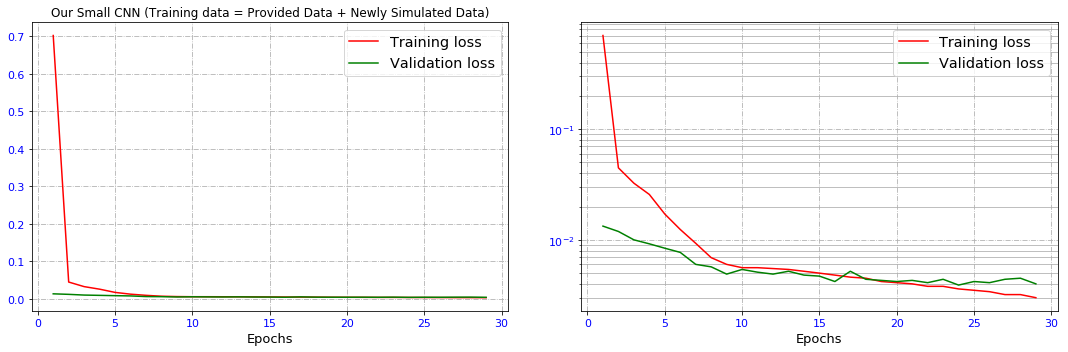

In [8]:
model_name = "003-model-conv-6-fc-4-data-02"
model_filename = "saved-models/" + model_name + ".h5"
history_filename = "saved-models/" + model_name + ".p"

checkpoint_file = model_filename

with open(history_filename, "rb") as file_pi:
    model_history = pickle.load(file_pi)

plot_title = "Our Small CNN (Training data = Provided Data + Newly Simulated Data)"
plot_file_name="images/" + model_name + "-a.jpg"

Sdc.plot_model_history(model_history["loss"], model_history["val_loss"], plot_title, plot_file_name)